<a href="https://colab.research.google.com/github/peterij/TM10007_Diagnosing_heart_disease/blob/Sylke/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TM10007 Machine Learning**

## Import dependencies and data

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import shutil
import subprocess
import shutil
import os
import stat
from os import path
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2

## if data.csv is not present download it from github
if not os.path.isfile("ecg_data.csv"):
    ## clone repo from githun
    if not os.path.isdir("tm10007_ml"):
        !git clone https://github.com/jveenland/tm10007_ml.git
    ## extract zip file
    if not os.path.isfile("tm10007_ml/ecg/ecg_data.csv"):
        with zipfile.ZipFile('tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
            zip_ref.extractall('tm10007_ml/ecg')
    ## move data file to root folder
    shutil.move('tm10007_ml/ecg/ecg_data.csv', 'ecg_data.csv')

    ## Delete cloned repo
    for root, dirs, files in os.walk("./tm10007_ml"):  
        for dir in dirs:
            os.chmod(path.join(root, dir), stat.S_IRWXU)
        for file in files:
            os.chmod(path.join(root, file), stat.S_IRWXU)
    shutil.rmtree('./tm10007_ml')

data = pd.read_csv('ecg_data.csv', index_col=0)

## Inspect imported data and clean missing data

### Plot number of missing data per features and per patient

In [ ]:
# exclude label column
values_features = data.drop(['label'], axis=1)

# plot the distribution of missing data per feature
num_zeros_features = (values_features == 0).sum(axis=0)
plt.scatter(range(len(num_zeros_features)),num_zeros_features)
plt.title("Distribution of number of missing data per feature")
plt.ylabel('Number of missing data')
plt.xlabel('Feature')
plt.show()

# plot the distribution of missing data per patient
num_zeros_patients=(values_features == 0).sum(axis=1)
plt.scatter(range(len(num_zeros_patients)),num_zeros_patients)
plt.title("Distribution of number of missing data per patient")
plt.ylabel('Number of missing data')
plt.xlabel('Patient')
plt.show()

### Delete rows with missing data

In [54]:
values_data = data.drop(['label'], axis=1)
mask = (values_data != 0).all(axis=1)
clean_data=data[mask]
dirty_data=data[~mask]

### Plot number of missing data per features and per patient after data cleanup

In [ ]:
# exclude label column
values_clean_data = clean_data.drop(['label'], axis=1)
# plot the distribution of missing data per feature
num_zeros_features = (values_clean_data == 0).sum(axis=0)
plt.scatter(range(len(num_zeros_features)),num_zeros_features)
plt.title("Distribution of number of missing data per feature")
plt.ylabel('Number of missing data')
plt.xlabel('Feature')
plt.show()

# plot the distribution of missing data per patient
num_zeros_patients=(values_clean_data == 0).sum(axis=1)
plt.scatter(range(len(num_zeros_patients)),num_zeros_patients)
plt.title("Distribution of number of missing data per patient")
plt.ylabel('Number of missing data')
plt.xlabel('Patient')
plt.show()

## Split data into test and train data

In [ ]:
x_train, x_test = model_selection.train_test_split(data, test_size=0.2)

ECG_ABNORMAL = data[data['label'] == 1]
ECG_NORMAL = data[data['label'] == 0]

x_train_abnormal, x_test_abnormal = model_selection.train_test_split(ECG_ABNORMAL, test_size=0.2)
x_train_normal, x_test_normal = model_selection.train_test_split(ECG_NORMAL,test_size = 0.2)

train_set = pd.concat([x_train_normal,x_train_abnormal])
test_set = pd.concat([x_test_normal,x_test_abnormal])


## Scale features of train and test set

In [ ]:
# scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
# fit the scaler on the train set
scaler.fit(train_set)
# transform both train and test data set with the scaler
# rename the column names to the ones from 'data' again
train_set_scaled = pd.DataFrame(scaler.transform(train_set))
train_set_scaled.columns=data.columns.values
test_set_scaled = pd.DataFrame(scaler.transform(test_set))
test_set_scaled.columns=data.columns.values

## Select best features

In [ ]:
# Extract the features and labels
y = train_set['label']
X = train_set.drop(['label'], axis=1)

# Select the k best features using the chi-squared test
selector = SelectKBest(chi2, k=33)
X_new = selector.fit_transform(X, y)

# Print the indices of the selected features
print(f'The k best features are {selector.get_support(indices=True)}')
scores = pd.DataFrame(selector.scores_)
sorted_scores = scores.sort_values(scores.columns[0],ascending=False)

threshold = 3500
below_threshold_to_nan = sorted_scores[sorted_scores > threshold]
above_threshold = below_threshold_to_nan.dropna()
print(above_threshold)
number_above_threshold = len(above_threshold)

label_1 = train_set_scaled.columns[6750]
print(label_1)


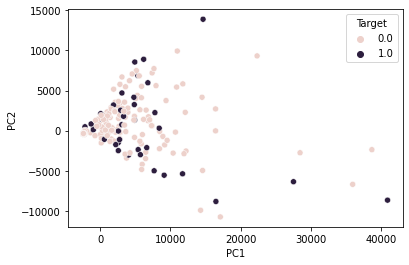

[0.59007038 0.10267812]
       0         1         2         3         4         5         6     \
0  0.125263  0.014951  0.005820  0.002962  0.001798  0.001145  0.000922   
1 -0.032241 -0.002466  0.000842 -0.000532 -0.000621 -0.000598 -0.002379   

       7         8         9     ...      8990      8991      8992      8993  \
0  0.000511  0.000571  0.000806  ...  0.000013  0.000013  0.000014  0.000013   
1 -0.000017  0.000268 -0.000295  ...  0.000043  0.000043  0.000045  0.000047   

       8994      8995      8996      8997      8998      8999  
0  0.000013  0.000012  0.000013  0.000014  0.000013  0.000013  
1  0.000043  0.000040  0.000044  0.000047  0.000046  0.000043  

[2 rows x 9000 columns]


In [76]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

y = train_set['label']
x = train_set.drop(['label'], axis=1)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x)

df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Target'] = y

sns.scatterplot(x='PC1', y='PC2', hue='Target', data=df_pca)
plt.show()

print(pca.explained_variance_ratio_)

loadings = pd.DataFrame(pca.components_)
sorted_loadings = loadings.sort_values(loadings.columns[0],ascending=False)
print(sorted_loadings)

Visualize the data 

In [ ]:
# Scatter plot of two features
import matplotlib.pyplot as plt

train_set_normal = train_set_scaled[train_set_scaled['label'] == 0.0]
train_set_abnormal = train_set_scaled[train_set_scaled['label'] == 1.0]

fig, ax = plt.subplots()
plt.scatter(x=train_set_normal['0_52'], y=train_set_normal['7_433'], c='blue', label='healthy subject', s=8)
plt.scatter(x=train_set_abnormal['0_52'], y=train_set_abnormal['7_433'], c='red', label='patient', s=8)
plt.legend(loc='lower right')
ax.set_xlabel('Feature 0_52')
ax.set_ylabel('Feature 7_52')
plt.show()